In [3]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

features_with_no_imp_at_least_twice = [
    'ACTIVE_CNT_CREDIT_PROLONG_SUM', 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'BURO_CNT_CREDIT_PROLONG_SUM', 'BURO_CREDIT_ACTIVE_Bad debt_MEAN', 'BURO_CREDIT_ACTIVE_nan_MEAN',
    'BURO_CREDIT_CURRENCY_currency 1_MEAN', 'BURO_CREDIT_CURRENCY_currency 2_MEAN', 'BURO_CREDIT_CURRENCY_currency 3_MEAN',
    'BURO_CREDIT_CURRENCY_currency 4_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX', 'BURO_CREDIT_DAY_OVERDUE_MEAN',
    'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN', 'BURO_CREDIT_TYPE_Interbank credit_MEAN', 'BURO_CREDIT_TYPE_Loan for business development_MEAN',
    'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN', 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
    'BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN', 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN',
    'BURO_CREDIT_TYPE_Real estate loan_MEAN', 'BURO_CREDIT_TYPE_Unknown type of loan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN',
    'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_STATUS_2_MEAN_MEAN', 'BURO_STATUS_3_MEAN_MEAN', 'BURO_STATUS_4_MEAN_MEAN', 'BURO_STATUS_5_MEAN_MEAN',
    'BURO_STATUS_nan_MEAN_MEAN', 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN', 'CC_AMT_DRAWINGS_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_SUM',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_AMT_INST_MIN_REGULARITY_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_VAR',
    'CC_AMT_RECIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_MAX', 'CC_AMT_TOTAL_RECEIVABLE_MIN', 'CC_AMT_TOTAL_RECEIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_VAR',
    'CC_CNT_DRAWINGS_ATM_CURRENT_MIN', 'CC_CNT_DRAWINGS_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MAX', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN',
    'CC_CNT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'CC_CNT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_SUM',
    'CC_CNT_INSTALMENT_MATURE_CUM_MAX', 'CC_CNT_INSTALMENT_MATURE_CUM_MIN', 'CC_COUNT', 'CC_MONTHS_BALANCE_MAX', 'CC_MONTHS_BALANCE_MEAN',
    'CC_MONTHS_BALANCE_MIN', 'CC_MONTHS_BALANCE_SUM', 'CC_NAME_CONTRACT_STATUS_Active_MAX', 'CC_NAME_CONTRACT_STATUS_Active_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_MAX', 'CC_NAME_CONTRACT_STATUS_Approved_MEAN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_SUM', 'CC_NAME_CONTRACT_STATUS_Approved_VAR', 'CC_NAME_CONTRACT_STATUS_Completed_MAX',
    'CC_NAME_CONTRACT_STATUS_Completed_MEAN', 'CC_NAME_CONTRACT_STATUS_Completed_MIN', 'CC_NAME_CONTRACT_STATUS_Completed_SUM', 'CC_NAME_CONTRACT_STATUS_Completed_VAR',
    'CC_NAME_CONTRACT_STATUS_Demand_MAX', 'CC_NAME_CONTRACT_STATUS_Demand_MEAN', 'CC_NAME_CONTRACT_STATUS_Demand_MIN', 'CC_NAME_CONTRACT_STATUS_Demand_SUM',
    'CC_NAME_CONTRACT_STATUS_Demand_VAR', 'CC_NAME_CONTRACT_STATUS_Refused_MAX', 'CC_NAME_CONTRACT_STATUS_Refused_MEAN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN',
    'CC_NAME_CONTRACT_STATUS_Refused_SUM', 'CC_NAME_CONTRACT_STATUS_Refused_VAR', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_SUM',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_VAR', 'CC_NAME_CONTRACT_STATUS_Signed_MAX', 'CC_NAME_CONTRACT_STATUS_Signed_MEAN', 'CC_NAME_CONTRACT_STATUS_Signed_MIN',
    'CC_NAME_CONTRACT_STATUS_Signed_SUM', 'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
    'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR', 'CC_SK_DPD_DEF_MAX',
    'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_MIN', 'CC_SK_DPD_SUM',
    'CC_SK_DPD_VAR', 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN', 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM', 'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'CLOSED_CNT_CREDIT_PROLONG_SUM', 'CLOSED_CREDIT_DAY_OVERDUE_MAX', 'CLOSED_CREDIT_DAY_OVERDUE_MEAN', 'CLOSED_MONTHS_BALANCE_MAX_MAX',
    'CNT_CHILDREN', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'ENTRANCES_MODE', 'FLAG_CONT_MOBILE',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLOORSMAX_MODE',
    'FONDKAPREMONT_MODE_not specified', 'FONDKAPREMONT_MODE_org spec account', 'FONDKAPREMONT_MODE_reg oper account', 'FONDKAPREMONT_MODE_reg oper spec account',
    'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house', 'LIVE_REGION_NOT_WORK_REGION',
    'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Single / not married',
    'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_With parents',
    'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student',
    'NAME_INCOME_TYPE_Unemployed', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people',
    'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied',
    'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MAX', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MEAN', 'NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX',
    'NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN', 'NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff',
    'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
    'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries',
    'OCCUPATION_TYPE_Security staff', 'OCCUPATION_TYPE_Waiters/barmen staff', 'ORGANIZATION_TYPE_Advertising', 'ORGANIZATION_TYPE_Agriculture',
    'ORGANIZATION_TYPE_Business Entity Type 1', 'ORGANIZATION_TYPE_Business Entity Type 2', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Culture',
    'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Government', 'ORGANIZATION_TYPE_Hotel', 'ORGANIZATION_TYPE_Housing',
    'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Industry: type 11', 'ORGANIZATION_TYPE_Industry: type 12',
    'ORGANIZATION_TYPE_Industry: type 13', 'ORGANIZATION_TYPE_Industry: type 2', 'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Industry: type 4',
    'ORGANIZATION_TYPE_Industry: type 5', 'ORGANIZATION_TYPE_Industry: type 6', 'ORGANIZATION_TYPE_Industry: type 7', 'ORGANIZATION_TYPE_Industry: type 8',
    'ORGANIZATION_TYPE_Insurance', 'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Mobile', 'ORGANIZATION_TYPE_Other', 'ORGANIZATION_TYPE_Postal',
    'ORGANIZATION_TYPE_Realtor', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_Security',
    'ORGANIZATION_TYPE_Security Ministries', 'ORGANIZATION_TYPE_Services', 'ORGANIZATION_TYPE_Telecom', 'ORGANIZATION_TYPE_Trade: type 1',
    'ORGANIZATION_TYPE_Trade: type 2', 'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Trade: type 4', 'ORGANIZATION_TYPE_Trade: type 5',
    'ORGANIZATION_TYPE_Trade: type 6', 'ORGANIZATION_TYPE_Trade: type 7',
    'ORGANIZATION_TYPE_Transport: type 1', 'ORGANIZATION_TYPE_Transport: type 2', 'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University',
    'ORGANIZATION_TYPE_XNA', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN', 'POS_NAME_CONTRACT_STATUS_Approved_MEAN', 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
    'POS_NAME_CONTRACT_STATUS_Demand_MEAN', 'POS_NAME_CONTRACT_STATUS_XNA_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
    'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_CLIENT_MEAN', 'PREV_CODE_REJECT_REASON_SYSTEM_MEAN', 'PREV_CODE_REJECT_REASON_VERIF_MEAN',
    'PREV_CODE_REJECT_REASON_XNA_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
    'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_XNA_MEAN',
    'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',
    'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN', 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN', 'PREV_NAME_GOODS_CATEGORY_Education_MEAN', 'PREV_NAME_GOODS_CATEGORY_Fitness_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Gardening_MEAN', 'PREV_NAME_GOODS_CATEGORY_Homewares_MEAN', 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN', 'PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN', 'PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Medicine_MEAN', 'PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN', 'PREV_NAME_GOODS_CATEGORY_Other_MEAN', 'PREV_NAME_GOODS_CATEGORY_Tourism_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN', 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN', 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
    'PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN', 'PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN',
    'PREV_NAME_PORTFOLIO_Cars_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Construction_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Industry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_TYPE_SUITE_Group of people_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN',
    'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
    'PREV_PRODUCT_COMBINATION_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'REFUSED_AMT_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MEAN',
    'REFUSED_RATE_DOWN_PAYMENT_MIN', 'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
    'WALLSMATERIAL_MODE_Wooden', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY'
'ACTIVE_CNT_CREDIT_PROLONG_SUM' 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN'
 'BURO_CNT_CREDIT_PROLONG_SUM' 'BURO_CREDIT_ACTIVE_Bad debt_MEAN'
 'BURO_CREDIT_ACTIVE_nan_MEAN' 'BURO_CREDIT_CURRENCY_currency 1_MEAN'
 'BURO_CREDIT_CURRENCY_currency 2_MEAN'
 'BURO_CREDIT_CURRENCY_currency 3_MEAN'
 'BURO_CREDIT_CURRENCY_currency 4_MEAN' 'BURO_CREDIT_CURRENCY_nan_MEAN'
 'BURO_CREDIT_DAY_OVERDUE_MAX' 'BURO_CREDIT_DAY_OVERDUE_MEAN'
 'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN'
 'BURO_CREDIT_TYPE_Interbank credit_MEAN'
 'BURO_CREDIT_TYPE_Loan for business development_MEAN'
 'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN'
 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN'
 'BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN'
 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN'
 'BURO_CREDIT_TYPE_Real estate loan_MEAN'
 'BURO_CREDIT_TYPE_Unknown type of loan_MEAN' 'BURO_CREDIT_TYPE_nan_MEAN'
 'BURO_MONTHS_BALANCE_MAX_MAX' 'BURO_STATUS_2_MEAN_MEAN'
 'BURO_STATUS_3_MEAN_MEAN' 'BURO_STATUS_4_MEAN_MEAN'
 'BURO_STATUS_5_MEAN_MEAN' 'BURO_STATUS_nan_MEAN_MEAN'
 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN' 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM'
 'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN' 'CLOSED_CNT_CREDIT_PROLONG_SUM'
 'CLOSED_CREDIT_DAY_OVERDUE_MAX' 'CLOSED_CREDIT_DAY_OVERDUE_MEAN'
 'CLOSED_MONTHS_BALANCE_MAX_MAX' 'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MEAN'
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM'
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN'
 'NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM'
 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MAX'
 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MEAN'
 'NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX'
 'NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN'
 'NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX'
 'PREV_CHANNEL_TYPE_Car dealer_MEAN' 'PREV_CHANNEL_TYPE_nan_MEAN'
 'PREV_CODE_REJECT_REASON_CLIENT_MEAN'
 'PREV_CODE_REJECT_REASON_SYSTEM_MEAN'
 'PREV_CODE_REJECT_REASON_VERIF_MEAN' 'PREV_CODE_REJECT_REASON_XNA_MEAN'
 'PREV_CODE_REJECT_REASON_nan_MEAN'
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN'
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN'
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN' 'PREV_NAME_CLIENT_TYPE_XNA_MEAN'
 'PREV_NAME_CLIENT_TYPE_nan_MEAN'
 'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN'
 'PREV_NAME_CONTRACT_STATUS_nan_MEAN' 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN'
 'PREV_NAME_CONTRACT_TYPE_nan_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Education_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Fitness_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Gardening_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Homewares_MEAN'
 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Medicine_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Other_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Tourism_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN'
 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN' 'PREV_NAME_GOODS_CATEGORY_nan_MEAN'
 'PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN'
 'PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN'
 'PREV_NAME_PAYMENT_TYPE_nan_MEAN' 'PREV_NAME_PORTFOLIO_Cars_MEAN'
 'PREV_NAME_PORTFOLIO_nan_MEAN' 'PREV_NAME_PRODUCT_TYPE_nan_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_Construction_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_Industry_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN'
 'PREV_NAME_TYPE_SUITE_Group of people_MEAN'
 'PREV_NAME_YIELD_GROUP_nan_MEAN'
 'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN'
 'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN'
 'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN'
 'PREV_PRODUCT_COMBINATION_nan_MEAN'
 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN' 'REFUSED_AMT_DOWN_PAYMENT_MAX'
 'REFUSED_AMT_DOWN_PAYMENT_MEAN' 'REFUSED_RATE_DOWN_PAYMENT_MIN'] 


In [4]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


In [5]:
a = ['ACTIVE_CNT_CREDIT_PROLONG_SUM' 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN'
 'BURO_CNT_CREDIT_PROLONG_SUM' 'BURO_CREDIT_ACTIVE_Bad debt_MEAN'
 'BURO_CREDIT_ACTIVE_nan_MEAN' 'BURO_CREDIT_CURRENCY_currency 1_MEAN'
 'BURO_CREDIT_CURRENCY_currency 2_MEAN'
 'BURO_CREDIT_CURRENCY_currency 3_MEAN'
 'BURO_CREDIT_CURRENCY_currency 4_MEAN' 'BURO_CREDIT_CURRENCY_nan_MEAN'
 'BURO_CREDIT_DAY_OVERDUE_MAX' 'BURO_CREDIT_DAY_OVERDUE_MEAN'
 'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN'
 'BURO_CREDIT_TYPE_Interbank credit_MEAN'
 'BURO_CREDIT_TYPE_Loan for business development_MEAN'
 'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN'
 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN'
 'BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN'
 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN'
 'BURO_CREDIT_TYPE_Real estate loan_MEAN'
 'BURO_CREDIT_TYPE_Unknown type of loan_MEAN' 'BURO_CREDIT_TYPE_nan_MEAN'
 'BURO_MONTHS_BALANCE_MAX_MAX' 'BURO_STATUS_2_MEAN_MEAN'
 'BURO_STATUS_3_MEAN_MEAN' 'BURO_STATUS_4_MEAN_MEAN'
 'BURO_STATUS_5_MEAN_MEAN' 'BURO_STATUS_nan_MEAN_MEAN'
 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN' 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM'
 'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN' 'CLOSED_CNT_CREDIT_PROLONG_SUM'
 'CLOSED_CREDIT_DAY_OVERDUE_MAX' 'CLOSED_CREDIT_DAY_OVERDUE_MEAN'
 'CLOSED_MONTHS_BALANCE_MAX_MAX' 'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MEAN'
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM'
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN'
 'NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM'
 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MAX'
 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MEAN'
 'NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX'
 'NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN'
 'NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX'
 'PREV_CHANNEL_TYPE_Car dealer_MEAN' 'PREV_CHANNEL_TYPE_nan_MEAN'
 'PREV_CODE_REJECT_REASON_CLIENT_MEAN'
 'PREV_CODE_REJECT_REASON_SYSTEM_MEAN'
 'PREV_CODE_REJECT_REASON_VERIF_MEAN' 'PREV_CODE_REJECT_REASON_XNA_MEAN'
 'PREV_CODE_REJECT_REASON_nan_MEAN'
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN'
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN'
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN'
 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN' 'PREV_NAME_CLIENT_TYPE_XNA_MEAN'
 'PREV_NAME_CLIENT_TYPE_nan_MEAN'
 'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN'
 'PREV_NAME_CONTRACT_STATUS_nan_MEAN' 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN'
 'PREV_NAME_CONTRACT_TYPE_nan_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Education_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Fitness_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Gardening_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Homewares_MEAN'
 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Medicine_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Other_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Tourism_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN'
 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN'
 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN' 'PREV_NAME_GOODS_CATEGORY_nan_MEAN'
 'PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN'
 'PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN'
 'PREV_NAME_PAYMENT_TYPE_nan_MEAN' 'PREV_NAME_PORTFOLIO_Cars_MEAN'
 'PREV_NAME_PORTFOLIO_nan_MEAN' 'PREV_NAME_PRODUCT_TYPE_nan_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_Construction_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_Industry_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN'
 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN'
 'PREV_NAME_TYPE_SUITE_Group of people_MEAN'
 'PREV_NAME_YIELD_GROUP_nan_MEAN'
 'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN'
 'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN'
 'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN'
 'PREV_PRODUCT_COMBINATION_nan_MEAN'
 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN' 'REFUSED_AMT_DOWN_PAYMENT_MAX'
 'REFUSED_AMT_DOWN_PAYMENT_MEAN' 'REFUSED_RATE_DOWN_PAYMENT_MIN'] 


In [6]:
features_with_no_imp_at_least_twice = [
    'ACTIVE_CNT_CREDIT_PROLONG_SUM', 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'BURO_CNT_CREDIT_PROLONG_SUM', 'BURO_CREDIT_ACTIVE_Bad debt_MEAN', 'BURO_CREDIT_ACTIVE_nan_MEAN',
    'BURO_CREDIT_CURRENCY_currency 1_MEAN', 'BURO_CREDIT_CURRENCY_currency 2_MEAN', 'BURO_CREDIT_CURRENCY_currency 3_MEAN',
    'BURO_CREDIT_CURRENCY_currency 4_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX', 'BURO_CREDIT_DAY_OVERDUE_MEAN',
    'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN', 'BURO_CREDIT_TYPE_Interbank credit_MEAN', 'BURO_CREDIT_TYPE_Loan for business development_MEAN',
    'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN', 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
    'BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN', 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN',
    'BURO_CREDIT_TYPE_Real estate loan_MEAN', 'BURO_CREDIT_TYPE_Unknown type of loan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN',
    'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_STATUS_2_MEAN_MEAN', 'BURO_STATUS_3_MEAN_MEAN', 'BURO_STATUS_4_MEAN_MEAN', 'BURO_STATUS_5_MEAN_MEAN',
    'BURO_STATUS_nan_MEAN_MEAN', 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN', 'CC_AMT_DRAWINGS_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_SUM',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_AMT_INST_MIN_REGULARITY_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_VAR',
    'CC_AMT_RECIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_MAX', 'CC_AMT_TOTAL_RECEIVABLE_MIN', 'CC_AMT_TOTAL_RECEIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_VAR',
    'CC_CNT_DRAWINGS_ATM_CURRENT_MIN', 'CC_CNT_DRAWINGS_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MAX', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN',
    'CC_CNT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'CC_CNT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_SUM',
    'CC_CNT_INSTALMENT_MATURE_CUM_MAX', 'CC_CNT_INSTALMENT_MATURE_CUM_MIN', 'CC_COUNT', 'CC_MONTHS_BALANCE_MAX', 'CC_MONTHS_BALANCE_MEAN',
    'CC_MONTHS_BALANCE_MIN', 'CC_MONTHS_BALANCE_SUM', 'CC_NAME_CONTRACT_STATUS_Active_MAX', 'CC_NAME_CONTRACT_STATUS_Active_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_MAX', 'CC_NAME_CONTRACT_STATUS_Approved_MEAN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_SUM', 'CC_NAME_CONTRACT_STATUS_Approved_VAR', 'CC_NAME_CONTRACT_STATUS_Completed_MAX',
    'CC_NAME_CONTRACT_STATUS_Completed_MEAN', 'CC_NAME_CONTRACT_STATUS_Completed_MIN', 'CC_NAME_CONTRACT_STATUS_Completed_SUM', 'CC_NAME_CONTRACT_STATUS_Completed_VAR',
    'CC_NAME_CONTRACT_STATUS_Demand_MAX', 'CC_NAME_CONTRACT_STATUS_Demand_MEAN', 'CC_NAME_CONTRACT_STATUS_Demand_MIN', 'CC_NAME_CONTRACT_STATUS_Demand_SUM',
    'CC_NAME_CONTRACT_STATUS_Demand_VAR', 'CC_NAME_CONTRACT_STATUS_Refused_MAX', 'CC_NAME_CONTRACT_STATUS_Refused_MEAN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN',
    'CC_NAME_CONTRACT_STATUS_Refused_SUM', 'CC_NAME_CONTRACT_STATUS_Refused_VAR', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_SUM',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_VAR', 'CC_NAME_CONTRACT_STATUS_Signed_MAX', 'CC_NAME_CONTRACT_STATUS_Signed_MEAN', 'CC_NAME_CONTRACT_STATUS_Signed_MIN',
    'CC_NAME_CONTRACT_STATUS_Signed_SUM', 'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
    'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR', 'CC_SK_DPD_DEF_MAX',
    'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_MIN', 'CC_SK_DPD_SUM',
    'CC_SK_DPD_VAR', 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN', 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM', 'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'CLOSED_CNT_CREDIT_PROLONG_SUM', 'CLOSED_CREDIT_DAY_OVERDUE_MAX', 'CLOSED_CREDIT_DAY_OVERDUE_MEAN', 'CLOSED_MONTHS_BALANCE_MAX_MAX',
    'CNT_CHILDREN', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'ENTRANCES_MODE', 'FLAG_CONT_MOBILE',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLOORSMAX_MODE',
    'FONDKAPREMONT_MODE_not specified', 'FONDKAPREMONT_MODE_org spec account', 'FONDKAPREMONT_MODE_reg oper account', 'FONDKAPREMONT_MODE_reg oper spec account',
    'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house', 'LIVE_REGION_NOT_WORK_REGION',
    'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Single / not married',
    'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_With parents',
    'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student',
    'NAME_INCOME_TYPE_Unemployed', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people',
    'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied',
    'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MAX', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MEAN', 'NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX',
    'NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN', 'NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff',
    'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
    'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries',
    'OCCUPATION_TYPE_Security staff', 'OCCUPATION_TYPE_Waiters/barmen staff', 'ORGANIZATION_TYPE_Advertising', 'ORGANIZATION_TYPE_Agriculture',
    'ORGANIZATION_TYPE_Business Entity Type 1', 'ORGANIZATION_TYPE_Business Entity Type 2', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Culture',
    'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Government', 'ORGANIZATION_TYPE_Hotel', 'ORGANIZATION_TYPE_Housing',
    'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Industry: type 11', 'ORGANIZATION_TYPE_Industry: type 12',
    'ORGANIZATION_TYPE_Industry: type 13', 'ORGANIZATION_TYPE_Industry: type 2', 'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Industry: type 4',
    'ORGANIZATION_TYPE_Industry: type 5', 'ORGANIZATION_TYPE_Industry: type 6', 'ORGANIZATION_TYPE_Industry: type 7', 'ORGANIZATION_TYPE_Industry: type 8',
    'ORGANIZATION_TYPE_Insurance', 'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Mobile', 'ORGANIZATION_TYPE_Other', 'ORGANIZATION_TYPE_Postal',
    'ORGANIZATION_TYPE_Realtor', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_Security',
    'ORGANIZATION_TYPE_Security Ministries', 'ORGANIZATION_TYPE_Services', 'ORGANIZATION_TYPE_Telecom', 'ORGANIZATION_TYPE_Trade: type 1',
    'ORGANIZATION_TYPE_Trade: type 2', 'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Trade: type 4', 'ORGANIZATION_TYPE_Trade: type 5',
    'ORGANIZATION_TYPE_Trade: type 6', 'ORGANIZATION_TYPE_Trade: type 7',
    'ORGANIZATION_TYPE_Transport: type 1', 'ORGANIZATION_TYPE_Transport: type 2', 'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University',
    'ORGANIZATION_TYPE_XNA', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN', 'POS_NAME_CONTRACT_STATUS_Approved_MEAN', 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
    'POS_NAME_CONTRACT_STATUS_Demand_MEAN', 'POS_NAME_CONTRACT_STATUS_XNA_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
    'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_CLIENT_MEAN', 'PREV_CODE_REJECT_REASON_SYSTEM_MEAN', 'PREV_CODE_REJECT_REASON_VERIF_MEAN',
    'PREV_CODE_REJECT_REASON_XNA_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
    'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_XNA_MEAN',
    'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',
    'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN', 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN', 'PREV_NAME_GOODS_CATEGORY_Education_MEAN', 'PREV_NAME_GOODS_CATEGORY_Fitness_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Gardening_MEAN', 'PREV_NAME_GOODS_CATEGORY_Homewares_MEAN', 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN', 'PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN', 'PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Medicine_MEAN', 'PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN', 'PREV_NAME_GOODS_CATEGORY_Other_MEAN', 'PREV_NAME_GOODS_CATEGORY_Tourism_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN', 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN', 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
    'PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN', 'PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN',
    'PREV_NAME_PORTFOLIO_Cars_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Construction_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Industry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_TYPE_SUITE_Group of people_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN',
    'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
    'PREV_PRODUCT_COMBINATION_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'REFUSED_AMT_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MEAN',
    'REFUSED_RATE_DOWN_PAYMENT_MIN', 'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
    'WALLSMATERIAL_MODE_Wooden', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
'ACTIVE_CNT_CREDIT_PROLONG_SUM', 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN',
 'BURO_CNT_CREDIT_PROLONG_SUM', 'BURO_CREDIT_ACTIVE_Bad debt_MEAN',
 'BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_currency 1_MEAN',
 'BURO_CREDIT_CURRENCY_currency 2_MEAN',
 'BURO_CREDIT_CURRENCY_currency 3_MEAN',
 'BURO_CREDIT_CURRENCY_currency 4_MEAN' 'BURO_CREDIT_CURRENCY_nan_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MAX' 'BURO_CREDIT_DAY_OVERDUE_MEAN',
 'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN',
 'BURO_CREDIT_TYPE_Interbank credit_MEAN',
 'BURO_CREDIT_TYPE_Loan for business development_MEAN',
 'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN',
 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
 'BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN',
 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN',
 'BURO_CREDIT_TYPE_Real estate loan_MEAN',
 'BURO_CREDIT_TYPE_Unknown type of loan_MEAN' 'BURO_CREDIT_TYPE_nan_MEAN',
 'BURO_MONTHS_BALANCE_MAX_MAX' 'BURO_STATUS_2_MEAN_MEAN',
 'BURO_STATUS_3_MEAN_MEAN' 'BURO_STATUS_4_MEAN_MEAN',
 'BURO_STATUS_5_MEAN_MEAN' 'BURO_STATUS_nan_MEAN_MEAN',
 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN' 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM',
 'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN' 'CLOSED_CNT_CREDIT_PROLONG_SUM',
 'CLOSED_CREDIT_DAY_OVERDUE_MAX' 'CLOSED_CREDIT_DAY_OVERDUE_MEAN',
 'CLOSED_MONTHS_BALANCE_MAX_MAX' 'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM',
 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MAX',
 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MEAN',
 'NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX',
 'NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN',
 'NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX',
 'PREV_CHANNEL_TYPE_Car dealer_MEAN' 'PREV_CHANNEL_TYPE_nan_MEAN',
 'PREV_CODE_REJECT_REASON_CLIENT_MEAN',
 'PREV_CODE_REJECT_REASON_SYSTEM_MEAN',
 'PREV_CODE_REJECT_REASON_VERIF_MEAN' 'PREV_CODE_REJECT_REASON_XNA_MEAN',
 'PREV_CODE_REJECT_REASON_nan_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN' 'PREV_NAME_CLIENT_TYPE_XNA_MEAN',
 'PREV_NAME_CLIENT_TYPE_nan_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN',
 'PREV_NAME_CONTRACT_STATUS_nan_MEAN' 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',
 'PREV_NAME_CONTRACT_TYPE_nan_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Education_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Fitness_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Gardening_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Homewares_MEAN',
 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Medicine_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Other_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Tourism_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN',
 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN' 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
 'PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN',
 'PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN',
 'PREV_NAME_PAYMENT_TYPE_nan_MEAN' 'PREV_NAME_PORTFOLIO_Cars_MEAN',
 'PREV_NAME_PORTFOLIO_nan_MEAN' 'PREV_NAME_PRODUCT_TYPE_nan_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_Construction_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_Industry_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN',
 'PREV_NAME_TYPE_SUITE_Group of people_MEAN',
 'PREV_NAME_YIELD_GROUP_nan_MEAN',
 'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN',
 'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN',
 'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
 'PREV_PRODUCT_COMBINATION_nan_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN' 'REFUSED_AMT_DOWN_PAYMENT_MAX',
 'REFUSED_AMT_DOWN_PAYMENT_MEAN' 'REFUSED_RATE_DOWN_PAYMENT_MIN'] 


In [7]:
len(features_with_no_imp_at_least_twice)

446

In [86]:
features_with_no_imp_at_least_twice.dtype()

AttributeError: 'list' object has no attribute 'dtype'

In [8]:
features_with_no_imp_at_least_twice.count( 'BURO_CREDIT_DAY_OVERDUE_MAX')

1

In [9]:


features_with_no_imp_at_least_twice.sort()  #将列表排序，sort是排序的意思

i = 0
for s in features_with_no_imp_at_least_twice:  #对于li中的每一个元素s
        while features_with_no_imp_at_least_twice.count(s) > 1:  #li.count(s)是统计里中s的个数
            features_with_no_imp_at_least_twice.remove(s) #删除li列表中的元素s
        i = i + 1
       
len(features_with_no_imp_at_least_twice)

358

In [10]:
features_with_no_imp_at_least_twice

['ACTIVE_CNT_CREDIT_PROLONG_SUM',
 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'BURO_CNT_CREDIT_PROLONG_SUM',
 'BURO_CREDIT_ACTIVE_Bad debt_MEAN',
 'BURO_CREDIT_ACTIVE_nan_MEAN',
 'BURO_CREDIT_CURRENCY_currency 1_MEAN',
 'BURO_CREDIT_CURRENCY_currency 2_MEAN',
 'BURO_CREDIT_CURRENCY_currency 3_MEAN',
 'BURO_CREDIT_CURRENCY_currency 4_MEAN',
 'BURO_CREDIT_CURRENCY_currency 4_MEANBURO_CREDIT_CURRENCY_nan_MEAN',
 'BURO_CREDIT_CURRENCY_nan_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MAX',
 'BURO_CREDIT_DAY_OVERDUE_MAXBURO_CREDIT_DAY_OVERDUE_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MEAN',
 'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN',
 'BURO_CREDIT_TYPE_Interbank credit_MEAN',
 'BURO_CREDIT_TYPE_Loan for business development_MEAN',
 'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN',
 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
 'BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN

In [11]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv("C://Users//95811//Desktop//kagggle//bureau.csv",nrows= num_rows)
    bb = pd.read_csv("C://Users//95811//Desktop//kagggle//bureau_balance.csv",nrows= num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = active_agg.columns.tolist()
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    for e in cols:
        bureau_agg['NEW_RATIO_BURO_' + e[0] + "_" + e[1].upper()] = bureau_agg['ACTIVE_' + e[0] + "_" + e[1].upper()] / bureau_agg['CLOSED_' + e[0] + "_" + e[1].upper()]
    
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


In [12]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv("C://Users//95811//Desktop//kagggle//previous_application.csv", nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = approved_agg.columns.tolist()
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    
    for e in cols:
        prev_agg['NEW_RATIO_PREV_' + e[0] + "_" + e[1].upper()] = prev_agg['APPROVED_' + e[0] + "_" + e[1].upper()] / prev_agg['REFUSED_' + e[0] + "_" + e[1].upper()]
    
    gc.collect()
    return prev_agg

In [13]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv("C://Users//95811//Desktop//kagggle//POS_CASH_balance.csv", nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [14]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv("C://Users//95811//Desktop//kagggle//installments_payments.csv", nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [15]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv("C://Users//95811//Desktop//kagggle//credit_card_balance.csv", nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [16]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
        dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'nthread': 4,
            'learning_rate': 0.02,  # 02,
            'num_leaves': 20,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 1,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 60, # 39.3259775,
            'seed': 0,
            'verbose': -1,
            'metric': 'auc',
            'is_unbalance':'true'
        }
        
        clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=False
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        sub_df = test_df[['SK_ID_CURR']].copy()
        sub_df['TARGET'] = sub_preds
        sub_df[['SK_ID_CURR', 'TARGET']].to_csv("C://Users//95811//Desktop//kagggle//submission_kernelyzq1.csv", index= False)
    display_importances(feature_importance_df)
    return feature_importance_df


In [24]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    """
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    """
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        print(df.shape)
        df.drop(features_with_no_imp_at_least_twice, axis=1, inplace=True)
        gc.collect()
        print(df.shape)
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)


In [2]:
import xgboost as xgt

In [ ]:
py -3 -m pip install xgboost-0.72-cp36-cp36m-win_amd64.whl

In [19]:
def kfold_xgt(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting xgt. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
""" 
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        dtrain = xgt.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
        dvalid = xgt.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)
#predictors = [x for x in train.columns if x not in [target, IDcol]]
        # xgt parameters found by Bayesian optimization
       
"""       
        clf = xgt.train(
             learning_rate = 0.1,
             n_estimators=1000,
             max_depth=5,
             min_child_weight=1,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             objective= 'binary:logistic',
             nthread=4,
             scale_pos_weight=1,
             seed=27
           
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        sub_df = test_df[['SK_ID_CURR']].copy()
        sub_df['TARGET'] = sub_preds
        sub_df[['SK_ID_CURR', 'TARGET']].to_csv("C://Users//95811//Desktop//kagggle//submission_kernelyzq2.csv", index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [59]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
 
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgt.DMatrix(dtrain[predictors].values, label=dtrain['TARGET'].values)
        cvresult = xgt.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
 
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['TARGET'],eval_metric='auc')
 
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
 
    #Print model report:
    print ("\nModel Report")
    metrics.accuracy_score(dtrain['TARGET'].values, dtrain_predictions)
    metrics.roc_auc_score(dtrain['TARGET'], dtrain_predprob)
    """
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    """

In [57]:
from sklearn import metrics

In [ ]:
modelfit(xgb1, train_df, predictors)

In [33]:
predictors= [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

In [32]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [35]:

xgb1 = xgt.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [42]:

modelfit(xgb1, train_df, predictors)

TypeError: cv() got an unexpected keyword argument 'show_progress'

In [15]:
bureau_and_balance(num_rows = None, nan_as_category = True)

KeyError: 'SK_ID_CURR'

In [16]:
previous_applications(num_rows = None, nan_as_category = True)

KeyError: 'DAYS_FIRST_DRAWING'

In [17]:
pos_cash(num_rows = None, nan_as_category = True)

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.000000,0.000000,0.0,0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.000000,0.000000,0.0,0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.0,0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.000000,0.090909,0.0,0,11
100006,-1,-9.619048,21,0,0.000000,0,0.000000,0.857143,0.0,0.0,0.0,0.095238,0.0,0.047619,0.000000,0.0,0,21
100007,-1,-33.636364,66,0,0.000000,0,0.000000,0.939394,0.0,0.0,0.0,0.045455,0.0,0.000000,0.015152,0.0,0,66
100008,-2,-43.662651,83,1294,339.060241,0,0.000000,0.939759,0.0,0.0,0.0,0.048193,0.0,0.000000,0.012048,0.0,0,83
100009,-1,-33.062500,64,0,0.000000,0,0.000000,0.890625,0.0,0.0,0.0,0.109375,0.0,0.000000,0.000000,0.0,0,64


In [18]:
installments_payments(num_rows = None, nan_as_category = True)

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.000000,1.000000,7.000000,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.000000,1.000000,19.000000,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.000000,1.000000,25.000000,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.000000,1.000000,3.000000,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.000000,1.000000,9.000000,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9
100006,2,0.0,0.000000,0.0,77.0,19.375000,310.0,1.000000,1.000000,16.000000,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16
100007,2,12.0,0.954545,63.0,31.0,4.590909,303.0,1.000000,0.954545,63.000000,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66
100008,2,1317.0,37.628571,1317.0,28.0,11.514286,403.0,1.000000,0.971429,34.000000,...,27702.964286,969603.750,227.160,432218.295,27360.502714,957617.595,-82.0,-1237.800000,-43323.0,35
100009,1,7.0,0.137255,7.0,23.0,8.725490,445.0,1.000000,1.000000,51.000000,...,9568.531765,487995.120,6155.280,17341.605,9568.531765,487995.120,-58.0,-864.411765,-44085.0,51


In [19]:
credit_card_balance(num_rows = None, nan_as_category = True)

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.500000,0.000,0.000,0.000000,0.000000e+00,0.000000e+00,...,0,0.000000,0,0.000000,0,0,0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.500000,0.000,189000.000,54482.111149,4.031676e+06,4.641321e+09,...,0,0.000000,0,0.000000,0,0,0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.000000,0.000,161420.220,18159.919219,1.743352e+06,1.869473e+09,...,0,0.000000,0,0.000000,0,0,0,0,0.0,96
100021,-18,-2,-10.0,-170,25.500000,0.000,0.000,0.000000,0.000000e+00,0.000000e+00,...,0,0.000000,0,0.000000,0,0,0,0,0.0,17
100023,-11,-4,-7.5,-60,6.000000,0.000,0.000,0.000000,0.000000e+00,0.000000e+00,...,0,0.000000,0,0.000000,0,0,0,0,0.0,8
100028,-49,-1,-25.0,-1225,204.166667,0.000,37335.915,8085.058163,3.961679e+05,6.232784e+07,...,0,0.000000,0,0.000000,0,0,0,0,0.0,49
100036,-13,-2,-7.5,-90,13.000000,0.000,0.000,0.000000,0.000000e+00,0.000000e+00,...,0,0.000000,0,0.000000,0,0,0,0,0.0,12
100042,-84,-1,-42.5,-3570,595.000000,0.000,93118.455,33356.183036,2.801919e+06,1.525076e+09,...,0,0.000000,0,0.000000,0,0,0,0,0.0,84
100043,-33,-1,-17.0,-561,93.500000,0.000,435861.585,208572.600000,6.882896e+06,3.787044e+10,...,0,0.000000,0,0.000000,0,0,0,0,0.0,33


In [20]:
kfold_lightgbm(df, 5, stratified = False, debug= False)

NameError: name 'df' is not defined

In [25]:
main(debug = False)
if __name__ == "__main__":
    submission_file_name = "submission_with selected_features.csv"
    with timer("Full model run"):
        main()

Train samples: 307511, test samples: 48744


AttributeError: __enter__

In [32]:
pos = pos_cash(num_rows = None, nan_as_category = True)

In [33]:
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()

14

In [34]:
ins = installments_payments()
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins

In [35]:
gc.collect()

14

In [99]:
df.dtype

,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,24700.5,406597.5,351000.0,202500.000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,35698.5,1293502.5,1129500.0,270000.000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,6750.0,135000.0,135000.0,67500.000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,29686.5,312682.5,297000.0,135000.000,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,21865.5,513000.0,513000.0,121500.000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,27517.5,490495.5,454500.0,99000.000,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,41301.0,1560726.0,1395000.0,171000.000,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,42075.0,1530000.0,1530000.0,360000.000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,33826.5,1019610.0,913500.0,112500.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0
9,9,20250.0,405000.0,405000.0,135000.000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
feat_importance=kfold_xgt(df, num_folds= 5, stratified= False)

Starting xgt. Train shape: (307511, 260), test shape: (48744, 260)


AttributeError: module 'xgboost' has no attribute 'Dataset'

(356251, 448)
(356251, 448)
Starting LightGBM. Train shape: (307507, 448), test shape: (48744, 448)
Fold  1 AUC : 0.784837
Fold  2 AUC : 0.779759
Fold  3 AUC : 0.781509
Fold  4 AUC : 0.781435
Fold  5 AUC : 0.783746
Full AUC score 0.782242


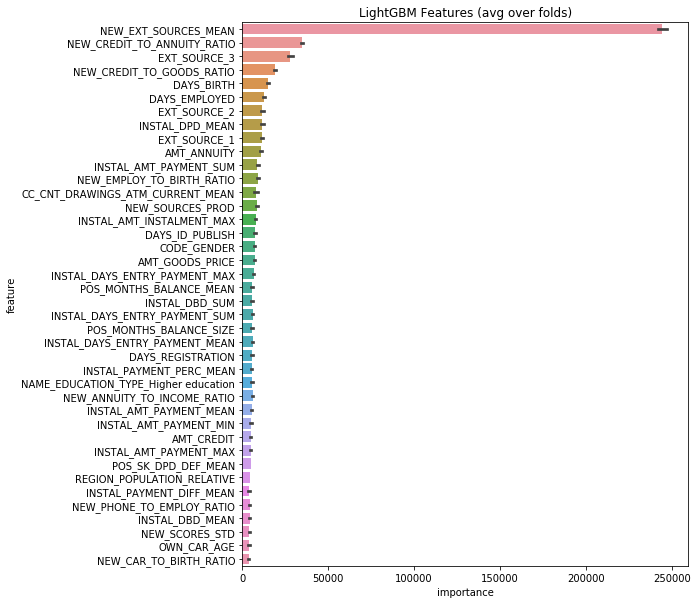

In [105]:
print(df.shape)
#df.drop(features_with_no_imp_at_least_twice, axis=1, inplace=True)
gc.collect()
print(df.shape)
feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False)

In [29]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", dataa=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lgbm_importances01.png')

In [103]:
test_df = pd.read_csv("C://Users//95811//Desktop//kagggle//application_test.csv", nrows= None)
sub_df = test_df[['SK_ID_CURR']].copy()
sub_df['TARGET'] = sub_preds
sub_df[['SK_ID_CURR', 'TARGET']].to_csv("C://Users//95811//Desktop//kagggle//submission_kernelyzq1.csv", index= False)

NameError: name 'sub_preds' is not defined

In [24]:
df=application_train_test(num_rows = None, nan_as_category = True)

Train samples: 307511, test samples: 48744


In [23]:
def application_train_test(num_rows = None, nan_as_category = True):
    # Read data and merge
    df = pd.read_csv("C://Users//95811//Desktop//kagggle//application_train.csv", nrows= num_rows)
    test_df = pd.read_csv("C://Users//95811//Desktop//kagggle//application_test.csv", nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    # Categorical features: Binary features and One-Hot encoding
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    del test_df
    gc.collect()
    return df

In [6]:
import random

In [7]:
help(random)

Help on module random:

NAME
    random - Random variable generators.

DESCRIPTION
        integers
        --------
               uniform within range
    
        sequences
        ---------
               pick random element
               pick random sample
               pick weighted random sample
               generate random permutation
    
        distributions on the real line:
        ------------------------------
               uniform
               triangular
               normal (Gaussian)
               lognormal
               negative exponential
               gamma
               beta
               pareto
               Weibull
    
        distributions on the circle (angles 0 to 2pi)
        ---------------------------------------------
               circular uniform
               von Mises
    
    General notes on the underlying Mersenne Twister core generator:
    
    * The period is 2**19937-1.
    * It is one of the most extensively tested generators

In [8]:
help(sorted)

Help on built-in function sorted in module builtins:

sorted(iterable, /, *, key=None, reverse=False)
    Return a new list containing all items from the iterable in ascending order.
    
    A custom key function can be supplied to customize the sort order, and the
    reverse flag can be set to request the result in descending order.

